In [675]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
import re

In [676]:
df=pd.read_csv('data/Tweets.csv', encoding='latin1')

In [677]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [678]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [679]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [680]:
google_pattern='[Gg]oogle\s[A-Za-z0-9]*'
def google_product_finder(x):
    s=''
    product=re.findall(google_pattern, x)
    s+=str(product).title()
    return s.replace('[', '').replace(']', '').replace("'", "")

In [681]:
df.loc[df['emotion_in_tweet_is_directed_at']=='Other Google product or service', 'emotion_in_tweet_is_directed_at']=df.loc[df['emotion_in_tweet_is_directed_at']=='Other Google product or service']['tweet_text'].apply(google_product_finder)

In [682]:
i_pattern='i[A-Z][A-Za-z0-9]*'
def i_product_finder(x):
    s=''
    product=re.findall(i_pattern, x)
    s=str(product).replace('[', '').replace(']', '').replace("'", "")
    return s

In [683]:
df.loc[df['emotion_in_tweet_is_directed_at']=='Other Apple product or service', 'emotion_in_tweet_is_directed_at']=df.loc[df['emotion_in_tweet_is_directed_at']=='Other Apple product or service']['tweet_text'].apply(i_product_finder)

In [684]:
def straggler_cleaner(x):
    x=x.lower()
    if 'google' in x and 'maps' in x:
        return 'Google Maps'
    elif 'google' in x and 'map' in x:
        return 'Google Maps'
    elif 'google' in x and 'photobooth' in x:
        return 'Google Photobooth'
    elif 'google' in x and 'route-around' in x:
        return 'Google Maps'
    elif 'google' in x and 'route around' in x:
        return 'Google Maps'
    elif 'google' in x and 'circles' in x:
        return 'Google Circles'
    elif "'circles'" in x:
        return 'Google Circles'
    elif 'google' in x:
        return 'Google'
    elif 'iphone charger' in x:
        return 'iPhone charger'
    elif 'itunes' in x:
        return 'iTunes'
    elif 'apple' and 'macs' in x:
        return 'Mac'
    elif 'apple' and 'mac' in x:
        return 'Mac'
    elif 'iphone' and 'case' in x:
        return 'iPhone case'
    elif 'apple' in x:
        return 'Apple'
    else:
        return ''

In [685]:
df.loc[df['emotion_in_tweet_is_directed_at']=='', 'emotion_in_tweet_is_directed_at']=df.loc[df['emotion_in_tweet_is_directed_at']=='']['tweet_text'].apply(straggler_cleaner)

In [686]:
df['positive_sentiment']=df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x =='Positive emotion' else 0)
df['negative_sentiment']=df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x =='Negative emotion' else 0)
top_8_sentiments=pd.concat([df.groupby('emotion_in_tweet_is_directed_at')['positive_sentiment'].sum().sort_values(ascending=False)[:8], df.groupby('emotion_in_tweet_is_directed_at')['negative_sentiment'].sum().sort_values(ascending=False)[:8]], axis=1, ignore_index=False)

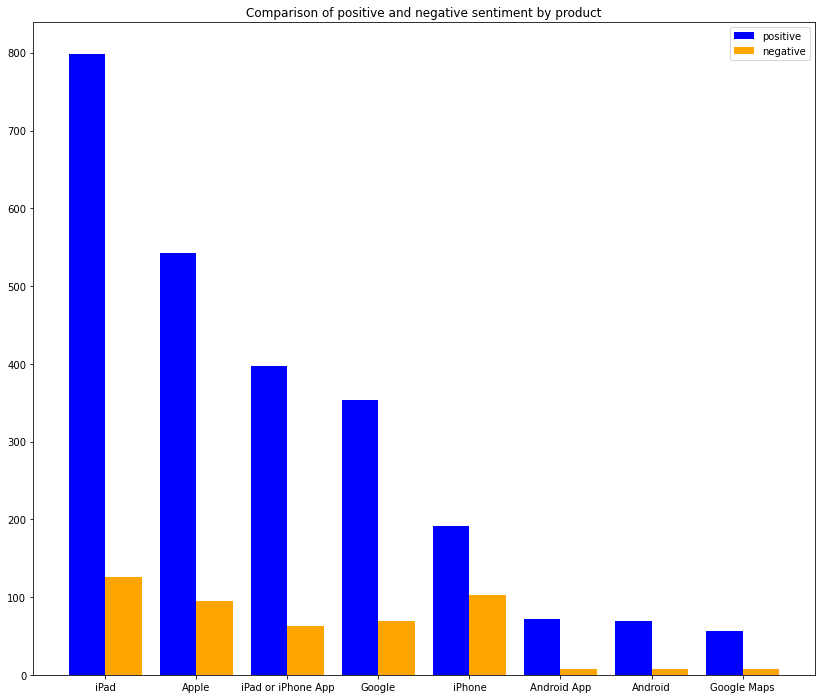

In [687]:
fig, ax=plt.subplots(figsize=(14,12))
width=0.4
ax.bar(np.arange(1,9,1)-width/2, top_8_sentiments['positive_sentiment'], width=width, color='blue', label='positive')
ax.bar(np.arange(1,9,1)+width/2, top_8_sentiments['negative_sentiment'], width=width, color='orange', label='negative')
ax.set_xticks(np.arange(1,9,1))
ax.set_xticklabels(top_8_sentiments.index)
ax.set_title('Comparison of positive and negative sentiment by product')
ax.legend();

In [688]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                              953
Apple                             662
iPad or iPhone App                470
Google                            439
iPhone                            305
                                 ... 
Google Apis                         1
Google For                          1
Google Logos                        1
Google Photobooth                   1
Google Should, Google Checkout      1
Name: emotion_in_tweet_is_directed_at, Length: 95, dtype: int64

#next step: clean tweets column